In [1]:
import carla
import random
import time

# 连接到CARLA服务器
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
map_name = 'Town05'
world = client.load_world(map_name)
world_map = world.get_map()
waypoints = world_map.generate_waypoints(2.0)

traffic_lights = world.get_actors().filter('traffic.traffic_light')


In [2]:
import pandas as pd
data_list = []

for waypoint in world_map.generate_waypoints(1.0):
    x = waypoint.transform.location.x
    y = waypoint.transform.location.y
    road_id = waypoint.road_id
    lane_id = waypoint.lane_id
    s = waypoint.s
    data_list.append([x, y, road_id, lane_id, s])

map_df = pd.DataFrame(data_list, columns=['x', 'y', 'road_id', 'lane_id', 's'])

In [4]:
import math
import pickle
from datetime import datetime

# 获取十字路口
junctions = [waypoint for waypoint in waypoints if waypoint.is_junction]

# 分组每个路口的路点
junctions_and_waypoints = {}
for waypoint in waypoints:
    for junction in junctions:
        if waypoint.is_junction and waypoint.junction_id == junction.junction_id:
            if junction not in junctions_and_waypoints:
                junctions_and_waypoints[junction] = []
            junctions_and_waypoints[junction].append(waypoint)

for junction, waypoints in junctions_and_waypoints.items():
    # 绘制十字路口前50米的路点
    previous_waypoint = junction.previous(50)[0]
    world.debug.draw_string(previous_waypoint.transform.location, 'Pre', draw_shadow=False,
                                color=carla.Color(r=255, g=0, b=0), life_time=100)
    

    # 获取十字路口的边界框
    junction_bounding_box = junction.get_junction().bounding_box

    # world.debug.draw_point(junction_bounding_box.location, size=0.1, color=carla.Color(255, 0, 0), life_time=100)
    # lane_width = previous_waypoint.lane_width * 4

    # world.debug.draw_point(junction_bounding_box.location + carla.Location(x=lane_width, y=0), size=0.1, color=carla.Color(255, 0, 0), life_time=100)
    # world.debug.draw_point(junction_bounding_box.location + carla.Location(x=0, y=lane_width), size=0.1, color=carla.Color(255, 0, 0), life_time=100)
    # world.debug.draw_point(junction_bounding_box.location + carla.Location(x=-lane_width, y=0), size=0.1, color=carla.Color(255, 0, 0), life_time=100)
    # world.debug.draw_point(junction_bounding_box.location + carla.Location(x=0, y=-lane_width), size=0.1, color=carla.Color(255, 0, 0), life_time=100)

    # 获取车道
    lane_id, road_id = previous_waypoint.lane_id, previous_waypoint.road_id
    road_data = map_df[(map_df['lane_id'] == lane_id) & (map_df['road_id'] == road_id)]
    first_row = road_data.iloc[0]
    # world.debug.draw_point(carla.Location(x=first_row['x'], y=first_row['y']), size=0.1, color=carla.Color(255, 0, 0), life_time=100)
    stop_line_y = first_row['y']

    lane_width = previous_waypoint.lane_width
    left = carla.Location(x=first_row['x'] + lane_width * 1.5, y=stop_line_y)
    right = carla.Location(x=first_row['x'] - lane_width * 0.5, y=stop_line_y)
    world.debug.draw_string(left, 'Left', draw_shadow=False,
                                color=carla.Color(r=255, g=0, b=0), life_time=100)
    world.debug.draw_string(right, 'Right', draw_shadow=False,
                                color=carla.Color(r=255, g=0, b=0), life_time=100)
    

    # 输出边界框的坐标
    # print(f"Junction ID: {junction.junction_id}")
    # print(f"Bounding Box Min: {junction_bounding_box.location}")
    # print(f"Bounding Box Max: {junction_bounding_box.location + junction_bounding_box.extent * 2.0}")

    # world.debug.draw_box(junction_bounding_box, junction_bounding_box.rotation, thickness=0.1, color=carla.Color(255, 0, 0), life_time=1000)

    # 提取边界框的位置和扩展
    # x, y = junction_bounding_box.location.x, junction_bounding_box.location.y
    # extent_x = junction_bounding_box.extent.x
    # extent_y = junction_bounding_box.extent.y
    # top_left = carla.Location(x - extent_x, y - extent_y, junction_bounding_box.location.z)
    # top_right = carla.Location(x + extent_x, y - extent_y, junction_bounding_box.location.z)
    # bottom_left = carla.Location(x - extent_x, y + extent_y, junction_bounding_box.location.z)
    # bottom_right = carla.Location(x + extent_x, y + extent_y, junction_bounding_box.location.z)
    # world.debug.draw_point(top_left, size=0.2, color=carla.Color(r=255, g=0, b=0), life_time=1000)
    # world.debug.draw_point(top_right, size=0.2, color=carla.Color(r=255, g=0, b=0), life_time=1000)
    # world.debug.draw_point(bottom_left, size=0.2, color=carla.Color(r=255, g=0, b=0), life_time=1000)
    # world.debug.draw_point(bottom_right, size=0.2, color=carla.Color(r=255, g=0, b=0), life_time=1000)



    # break
    trajectory_data = []
    num = 0
    while True:
        # 设置目标路口的红绿灯为绿色
        for traffic_light in traffic_lights:
            traffic_light.set_state(carla.TrafficLightState.Green)

        vehicle_bp = random.choice(world.get_blueprint_library().filter('vehicle.*'))
        vehicle = world.try_spawn_actor(vehicle_bp, previous_waypoint.transform)
        
        if vehicle is not None:
            print(f'Created {vehicle_bp.id}')
            num += 1
            # 启用车辆自动驾驶
            vehicle.set_autopilot(True)
            
            # 设置车头方向
            direction_vector = previous_waypoint.next(2.0)[0].transform.location - previous_waypoint.transform.location
            direction_vector = direction_vector / direction_vector.length()
            yaw = math.atan2(direction_vector.y, direction_vector.x) * (180.0 / math.pi)
            new_transform = carla.Transform(location=vehicle.get_location(), rotation=carla.Rotation(yaw=yaw))
            vehicle.set_transform(new_transform)

            start_time = time.time()
            trajectory = []

            # 记录车辆轨迹，持续10秒
            while time.time() - start_time <= 10:
                # 获取车辆的位置和朝向
                vehicle_location = vehicle.get_location()
                vehicle_rotation = vehicle.get_transform().rotation

                trajectory.append([vehicle_location.x, vehicle_location.y, vehicle_rotation.yaw])
                # world.debug.draw_point(vehicle_location, size=0.1, color=carla.Color(0, 255, 0), life_time=1000)
                time.sleep(0.1)

            trajectory_data.append(trajectory[:])

        if num >= 50:
            current_time = datetime.now().strftime("%Y%m%d%H%M%S")
            pickle_filename = f"./traj/vehicle_trajectory_{current_time}.pkl"
            with open(pickle_filename, 'wb') as pickle_file:
                pickle.dump(trajectory_data, pickle_file)
            break
    break


Created vehicle.diamondback.century
Created vehicle.kawasaki.ninja


KeyboardInterrupt: 

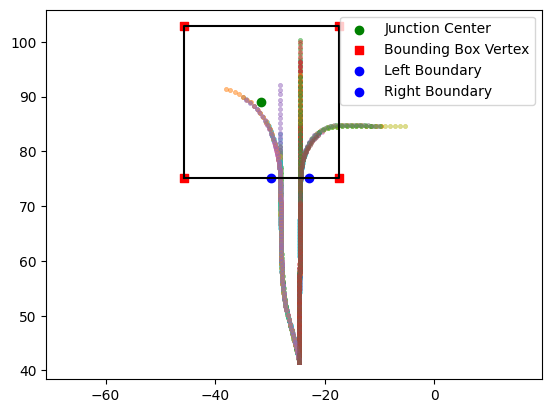

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 读取轨迹数据
with open("vehicle_trajectory.pkl", 'rb') as pickle_file:
    trajectory_data = pickle.load(pickle_file)

# 创建一个图形
plt.figure()

# 绘制轨迹
for i in range(len(trajectory_data)):
    traj = np.array(trajectory_data[i])
    if traj[0][0] < 20:
        continue
    plt.scatter(-traj[:, 0], traj[:, 1], marker='.', linewidth=0.5, alpha=0.5)

# 获取 junction 边界框信息
x, y = -junction_bounding_box.location.x, junction_bounding_box.location.y
extent_x, extent_y = junction_bounding_box.extent.x, junction_bounding_box.extent.y

# 绘制 junction 点和边界框
plt.scatter(x, y, color='green', label='Junction Center')
plt.scatter(x - extent_x, y - extent_y, color='red', label='Bounding Box Vertex', marker='s')
plt.scatter(x + extent_x, y - extent_y, color='red', marker='s')
plt.scatter(x - extent_x, y + extent_y, color='red', marker='s')
plt.scatter(x + extent_x, y + extent_y, color='red', marker='s')

# 连接四个点
plt.plot([x - extent_x, x + extent_x, x + extent_x, x - extent_x, x - extent_x],
         [y - extent_y, y - extent_y, y + extent_y, y + extent_y, y - extent_y], color='black')

# 绘制左右边界
plt.scatter(-left.x, left.y, color='blue', label='Left Boundary')
plt.scatter(-right.x, right.y, color='blue', label='Right Boundary')

# 设置图形的纵横比
plt.axis('equal')

# 显示图例
plt.legend()

# 显示图形
# plt.savefig('trajectory_and_junction.png', dpi=300, bbox_inches='tight')


(-47.17263908386231, -15.88750343322754, 38.39083881378174, 105.86864070892334)

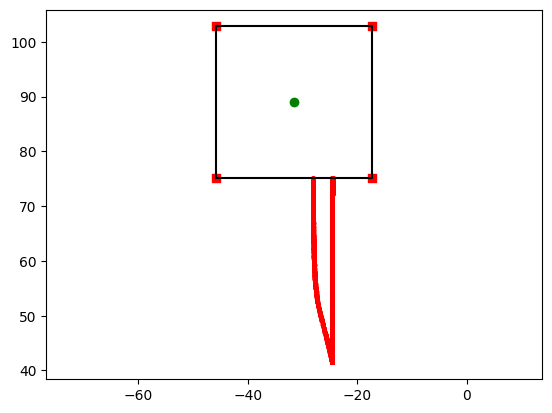

In [ ]:
# 处理数据
data_and_label = []
for i in range(len(trajectory_data)):
    traj = np.array(trajectory_data[i])
    if traj[0][0] < 20:
        continue
    data = []
    for j in range(len(traj)):
        if traj[j][1] < stop_line_y:
            data.append(traj[j])
            plt.scatter(-traj[j][0], traj[j][1], marker='.', color='r', linewidth=0.5, alpha=0.5)
    if traj[-1][0] < left.x:
        label = 0 # 左转
    elif traj[-1][0] > right.x:
        label = 2 # 右转
    else:
        label = 1 # 直行
    data_and_label.append([data[-20:], label])

# 绘制 junction 点和边界框
plt.scatter(x, y, color='green', label='Junction Center')
plt.scatter(x - extent_x, y - extent_y, color='red', label='Bounding Box Vertex', marker='s')
plt.scatter(x + extent_x, y - extent_y, color='red', marker='s')
plt.scatter(x - extent_x, y + extent_y, color='red', marker='s')
plt.scatter(x + extent_x, y + extent_y, color='red', marker='s')
# 连接四个点
plt.plot([x - extent_x, x + extent_x, x + extent_x, x - extent_x, x - extent_x],
         [y - extent_y, y - extent_y, y + extent_y, y + extent_y, y - extent_y], color='black')
plt.axis('equal')
    # data.append([traj, label])

pickle_filename = "data_and_label.pkl"
with open(pickle_filename, 'wb') as pickle_file:
    pickle.dump(data_and_label, pickle_file)

In [12]:
data_and_label = pickle.load(open('data_and_label.pkl', "rb"))

In [14]:
len(data_and_label)

109

In [19]:
data_and_label[0][0]

[array([24.58595085, 64.99861908, 90.02336884]),
 array([24.58569717, 65.61715698, 90.02336884]),
 array([24.5854454 , 66.21613312, 90.02336884]),
 array([24.58523369, 66.73648071, 90.02327728]),
 array([24.58504868, 67.22264862, 90.02323151]),
 array([24.58485031, 67.70072174, 90.02324677]),
 array([24.5846386 , 68.22671509, 90.02328491]),
 array([24.58442879, 68.75537872, 90.02333069]),
 array([24.58418846, 69.32843781, 90.02334595]),
 array([24.58396912, 69.86558533, 90.02332306]),
 array([24.58325958, 70.38891602, 90.04512787]),
 array([24.57125664, 70.90894318, 90.56890869]),
 array([24.55410194, 71.42897034, 91.11502838]),
 array([24.5350647 , 71.93722534, 91.51768494]),
 array([24.51517296, 72.43206024, 91.80763245]),
 array([24.49503517, 72.91269684, 92.01880646]),
 array([24.4742775 , 73.3953476 , 92.17817688]),
 array([24.4532032 , 73.87600708, 92.29710388]),
 array([24.43222618, 74.34738922, 92.38507843]),
 array([24.41164589, 74.80473328, 92.45042419])]

In [21]:
data_and_label[0][1]

0

: 